In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
pd.options.display.max_rows = 10


In [2]:
#brighton_points = gpd.read_file("../insight_project_dc/brighton/brighton_points.shp")
brighton_sidewalks = gpd.read_file("../insight_project_dc/brighton/brighton_sidewalks/brighton_sidewalks.shp")
EPSG_26919 = "EPSG:26919"

from shapely.ops import snap, unary_union
from shapely.geometry import Point, LineString, MultiLineString

def ls_to_mls(linestring):
    linelist = linestring.coords
    pairlist = list(zip(linelist, linelist[1:]))
    return MultiLineString(pairlist)
    

brighton_sidewalks['geometry'] = brighton_sidewalks.geometry.map(ls_to_mls)
brighton_sidewalks = brighton_sidewalks.explode().reset_index(drop=True)
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

,street_id,forward,geometry


In [71]:
brighton_crosswalks = gpd.read_file("../insight_project_dc/brighton/brighton_crosswalks/brighton_crosswalks.shp")

In [72]:
def snap_endpoints(linestring, geom, tol):
    linelist = linestring.coords
    assert len(linelist) == 2
    p0 = snap(Point(linelist[0]), geom, tol)
    p1 = snap(Point(linelist[-1]), geom, tol)  
    #return LineString([Point(p0)] + list(map(Point, linelist[1:-1])) + [Point(pn)])
    return LineString([Point(p0), Point(p1)])
    

points = list(map(Point, (list(set([point for ls in list(
    brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values
    ) + list(brighton_crosswalks.geometry.map(lambda x : list(x.coords)).values) for point in ls]
)))))
len(points)

14317

## Snapping

In [73]:
all_sidewalks = unary_union(pd.Series(brighton_sidewalks.geometry))
all_sidewalks
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

,street_id,forward,geometry,u,v,key,osmid


In [6]:
len(brighton_sidewalks)

10749

In [8]:
brighton_sidewalks.geometry = brighton_sidewalks.geometry.apply(lambda x: snap_endpoints(x, all_sidewalks, .5))
#brighton_sidewalks.geometry.head(10).apply(lambda x: snap_endpoints(x, all_sidewalks, 1))
#brighton_sidewalks.geometry = brighton_sidewalks.geometry.apply(lambda x: snap_endpoints(x, all_sidewalks, .1))
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

,street_id,forward,geometry


In [9]:
brighton_sidewalks.to_file("brighton_sidewalks_processed.shp")

In [74]:
import pickle as pkl
brighton_sidewalks = gpd.read_file("brighton_sidewalks_processed.shp")
    
brighton_sidewalks = brighton_sidewalks.to_crs("EPSG:4326")
    
#all_sidewalks = unary_union(brighton_sidewalks.geometry)
#brighton_crosswalks.geometry = brighton_crosswalks.geometry.apply(lambda x: snap_endpoints(x, all_sidewalks, .5))
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : len(x.coords)) != 2]

,street_id,forward,geometry


In [34]:
#brighton_sidewalks.crs, brighton_sidewalks, brighton_crosswalks.crs, brighton_crosswalks
brighton_sidewalks.columns

Index(['street_id', 'forward', 'geometry'], dtype='object')

In [27]:
brighton_crosswalks.to_file("brighton_crosswalks_processed.shp")

In [35]:
brighton_crosswalks = gpd.read_file("brighton_crosswalks_processed.shp")
brighton_sidewalks[brighton_sidewalks.geometry.map(lambda x : type(x) == MultiLineString)]

,street_id,forward,geometry


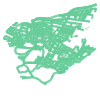

In [37]:
all_sidewalks =  unary_union(brighton_sidewalks.geometry)
sidewalks = brighton_sidewalks.geometry
all_sidewalks


In [44]:
# can't just use split because some crosswalks will be too short
# good news: every crosswalk is a single segment
# >> brighton_crosswalks[brighton_crosswalks.geometry.map(lambda x : len(x.coords)) != 2]
# for each segment:
## for each endpoint:
### find the nearest point on the sidewalks
### split the sidewalk at that point
## replace crosswalk with a segment between the new points
import shapely.ops as ops
from shapely.geometry import GeometryCollection

# TODO: must be built-in!
def find_sidewalk(pt):
    # just sort by minimum distance!
    ind, seg = min(sidewalks.items(), key=lambda x : x[1].distance(pt))
    return ind, seg
#        if ((pt.almost_equals(Point(seg.coords[0]))) 
#            or (pt.almost_equals(Point(seg.coords[0]))) 
#            or seg.contains(Point(pt))):
#                print("ok")
#                return ind, seg
#        print("couldn't find one")
            
def fix_endpoint(endpt):
    # split the sidewalk at that point
    # we can't use ops.split because of precision problems
    nearest_sw_ind, nearest_sidewalk = find_sidewalk(endpt)
    if type(nearest_sidewalk) == GeometryCollection:
        assert len(nearest_sidewalk.geoms) == 1
        nearest_sidewalk = nearest_sidewalk.geoms[0]
    nearest_point = nearest_sidewalk.interpolate(nearest_sidewalk.project(endpt))
    swp0, swp1 = nearest_sidewalk.coords
    new_sidewalk0 = LineString([Point(swp0), nearest_point])
    new_sidewalk1 = LineString([nearest_point, Point(swp1)])

    
    # replace the sidewalk geometry with the split geometry
    brighton_sidewalks.geometry.loc[nearest_sw_ind] = new_sidewalk0
    new_row = gpd.GeoDataFrame(brighton_sidewalks.loc[nearest_sw_ind])
    new_row.geometry = gpd.GeoSeries(new_sidewalk1)
    brighton_sidewalks.append(new_row, ignore_index=True, sort=False)
    
    #brighton_sidewalks.explode().reset_index(drop=True) # FIXME: should be row insert instead
    assert all(brighton_sidewalks.geometry.map(lambda x : type(x) == LineString))
    
    # return the nearest point because we need to use that to build the new crosswalk
    return nearest_point

# named because sw segments get 'fixed' by fix_endpoint
def fix_cw_segment(seg):
    p0,p1 = seg.coords
    new_p0 = fix_endpoint(Point(p0))
    new_p1 = fix_endpoint(Point(p1))
    return(LineString([new_p0, new_p1]))

brighton_crosswalks.geometry = brighton_crosswalks.geometry.map(fix_cw_segment)

In [161]:
def progressive_snap_to_sidewalks(pt, tol):
#    print("snapping")
    while True:
        snapped = snap(pt, all_sidewalks, tol)
        if snapped == pt:
            tol = tol * 1.1
#            print(tol)
        else:
            break
    assert snapped.touches(all_sidewalks), snapped.distance(all_sidewalks)
    return snapped
        
def snap_edge(edge, tol):
    p0,p1 = edge.coords
    new_p0 = progressive_snap_to_sidewalks(Point(p0), tol)
    new_p1 = progressive_snap_to_sidewalks(Point(p1), tol)
    return LineString([new_p0, new_p1])

In [163]:
brighton_sidewalks = brighton_sidewalks.to_crs(EPSG_26919)
brighton_crosswalks = brighton_crosswalks.to_crs(EPSG_26919)

In [164]:
snapped_cw = brighton_crosswalks.geometry.map(snap_edge,.5)

In [124]:
brighton_crosswalks.geometry = snapped_cw

In [125]:
brighton_crosswalks.to_file("brighton_crosswalks_diditwork.shp")
brighton_sidewalks.to_file("brighton_sidewalks_diditwork.shp")

In [126]:
brighton_crosswalks

,layer,highway,footway,geometry
0,0,footway,crossing,LINESTRING (-71.17456356025808 42.350276777230...
1,0,footway,crossing,LINESTRING (-71.17452718481751 42.350245522348...
2,0,footway,crossing,LINESTRING (-71.1742599622831 42.3507992446600...
3,0,footway,crossing,LINESTRING (-71.17424443019993 42.350872567928...
4,0,footway,crossing,LINESTRING (-71.17384515185557 42.351522262491...
...,...,...,...,...
1804,0,footway,crossing,LINESTRING (-71.13546655578875 42.364718463523...
1805,0,footway,crossing,LINESTRING (-71.13546618130573 42.364816645292...
1806,0,footway,crossing,LINESTRING (-71.13545531866691 42.364761654705...
1807,0,footway,crossing,LINESTRING (-71.1353768324929 42.3631600828948...


In [49]:
#brighton_crosswalks.to_file("new_crosswalks.shp")
def safe_linemerge(x):
    if type(x) == LineString:
        return x
    else:
        return ops.linemerge(x)

# suspicious that this has the same length as brighton_sidewalks.geometry!!
#brighton_sidewalks.geometry.map(safe_linemerge).map(ls_to_mls).explode().reset_index(drop=True)

#brighton_sidewalks.geometry = brighton_sidewalks.geometry.map(safe_linemerge).map(ls_to_mls).explode().reset_index(drop=True)

## back to it 

In [127]:
from shapely.geometry import Point
points = list(map(Point, (list(set([point for ls in list(
    brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values
    ) + list(brighton_crosswalks.geometry.map(lambda x : list(x.coords)).values) for point in ls]
)))))
len(points)

10753

In [128]:
brighton_crosswalks

,layer,highway,footway,geometry
0,0,footway,crossing,LINESTRING (-71.17456356025808 42.350276777230...
1,0,footway,crossing,LINESTRING (-71.17452718481751 42.350245522348...
2,0,footway,crossing,LINESTRING (-71.1742599622831 42.3507992446600...
3,0,footway,crossing,LINESTRING (-71.17424443019993 42.350872567928...
4,0,footway,crossing,LINESTRING (-71.17384515185557 42.351522262491...
...,...,...,...,...
1804,0,footway,crossing,LINESTRING (-71.13546655578875 42.364718463523...
1805,0,footway,crossing,LINESTRING (-71.13546618130573 42.364816645292...
1806,0,footway,crossing,LINESTRING (-71.13545531866691 42.364761654705...
1807,0,footway,crossing,LINESTRING (-71.1353768324929 42.3631600828948...


In [129]:
from shapely.geometry import Point
points = list(map(Point, (list(set([point for ls in list(brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_sw_points = gpd.GeoDataFrame(points)
brighton_sw_points.crs = "EPSG:4326"
brighton_sw_points.geometry = brighton_sw_points[0]

points = list(map(Point, (list(set([point for ls in list(brighton_crosswalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_cw_points = gpd.GeoDataFrame(points)
brighton_cw_points.crs = "EPSG:4326"
brighton_cw_points.geometry = brighton_cw_points[0]

brighton_sw_points.geometry, brighton_cw_points.geometry, brighton_sw_points.crs, brighton_cw_points.crs

(0        POINT (-71.14165570983711 42.3453136920528)
 1        POINT (-71.1448939215696 42.34005989490161)
 2       POINT (-71.16091660233474 42.35636138968006)
 3       POINT (-71.15190966866531 42.35163073021489)
 4       POINT (-71.14523836360593 42.36218202179332)
                             ...                     
 8063    POINT (-71.15102578150321 42.34619265046886)
 8064    POINT (-71.15479013847798 42.33832038245387)
 8065    POINT (-71.15121061114549 42.34902966885677)
 8066     POINT (-71.1462299143427 42.36192118711539)
 8067    POINT (-71.15865122044103 42.35889092629264)
 Name: geometry, Length: 8068, dtype: geometry,
 0       POINT (-71.15267858768551 42.34577739032937)
 1       POINT (-71.15203031465251 42.34993256308441)
 2       POINT (-71.14547820287051 42.36173056210384)
 3        POINT (-71.1392086989197 42.34591447176926)
 4       POINT (-71.13730443422355 42.34610020681784)
                             ...                     
 2858    POINT (-71.16308752682295

In [156]:
len_sw = len(list(brighton_sw_points.geometry.map(lambda x : x.coords)))
len_cw = len(list(brighton_cw_points.geometry.map(lambda x : x.coords)))
sw_coord_dict = dict(list(set(zip(list(brighton_sw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw)))))
cw_coord_dict = dict(list(set(zip(list(brighton_cw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw, len_sw + len_cw)))))
len(set(cw_coord_dict.keys()).difference(set(sw_coord_dict.keys()))), len(cw_coord_dict.keys())

(2685, 2863)

In [150]:
from shapely.coords import CoordinateSequence
brighton_sidewalks['u'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sidewalks['v'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_sidewalks['key'] = 0

brighton_crosswalks['u'] = brighton_crosswalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_crosswalks['v'] = brighton_crosswalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_crosswalks['key'] = 1


KeyError: (-71.17456356025808, 42.35027677723086)

In [132]:
brighton_sw_points['x'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][1])
brighton_sw_points['y'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][0])

brighton_cw_points['x'] = brighton_cw_points.geometry.map(lambda x : x.coords[0][1])
brighton_cw_points['y'] = brighton_cw_points.geometry.map(lambda x : x.coords[0][0])

In [133]:
brighton_sw_points['id'] = brighton_sw_points.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sw_points['osmid'] = brighton_sw_points.id

brighton_cw_points['id'] = brighton_cw_points.geometry.map(lambda x : cw_coord_dict[x.coords[0]])
brighton_cw_points['osmid'] = brighton_cw_points.id

In [134]:
brighton_sidewalks['osmid'] = brighton_sidewalks.key.map(lambda x : x * 10000)
brighton_crosswalks['osmid'] = brighton_sidewalks.key.map(lambda x : x * 10000000)

In [135]:
def union_graph(points_gdfs, edges_gdfs, crs):
    points_df = pd.concat([pd.DataFrame(gdf) for gdf in points_gdfs], ignore_index=True, sort=False)
    edges_df = pd.concat([pd.DataFrame(gdf) for gdf in edges_gdfs], ignore_index=True, sort=False)
    
    points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs).to_crs(crs)
    edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs).to_crs(crs)
    return ox.utils_graph.graph_from_gdfs(points_gdf, edges_gdf)


brighton_G = union_graph([brighton_cw_points, brighton_sw_points], [brighton_crosswalks, brighton_sidewalks], "EPSG:4326")


In [136]:
brighton_G_sw = ox.graph_from_gdfs(brighton_sw_points, brighton_sidewalks)

In [64]:
print(len(brighton_sw_points), len(brighton_cw_points), len(brighton_G.nodes) - (len(brighton_sw_points) + len(brighton_cw_points)))
print(len(brighton_sidewalks), len(brighton_crosswalks), len(brighton_G.edges) - (len(brighton_sidewalks) + len(brighton_crosswalks)))

10708 3424 0
10749 1809 -13


In [137]:
spn = ox.utils_graph.count_streets_per_node(brighton_G) 
dead_nodes = [node for node in spn if spn[node] ==0]
print(len(dead_nodes))
#len(dead_nodes), len(brighton_G.nodes)
brighton_G.remove_nodes_from(dead_nodes)
len(brighton_G.nodes)

0


10931

In [138]:
brighton_G_proj = ox.project_graph(brighton_G, to_crs=EPSG_26919)

In [139]:
import geocoder
g1 = geocoder.osm("34 Claymoss Rd, Boston, MA")
g3 = geocoder.osm("90 monastery rd, Boston, MA")
p1 = (g1.json['lng'], g1.json['lat'])
p3 = (g3.json['lng'], g3.json['lat'])
n1, d1 = ox.get_nearest_node(brighton_G,p1, method='haversine', return_dist=True)
n3, d3 = ox.get_nearest_node(brighton_G,p3, method='haversine', return_dist=True)
p1, n1, d1, p3, n3, d3

((-71.14555578169282, 42.3441889),
 2267,
 42.81223008953763,
 (-71.14757248275862, 42.344374724137936),
 7113,
 5.019181827563117)

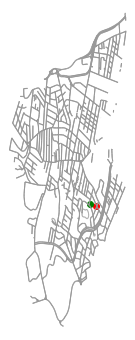

In [140]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(brighton_G, show=False, close=False)

ax.scatter(p1[0],p1[1], c='red')
ax.scatter(p3[0],p3[1], c='green')

plt.show()


In [143]:
import networkx as nx
len(nx.shortest_path(brighton_G.to_undirected(), n1, n3))

NetworkXNoPath: No path between 2267 and 7113.